---
# Deep Learning Assignment 1
---

In [50]:
import tensorflow as tf
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.applications.resnet_v2 import preprocess_input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
seed = 1234
tf.random.set_seed(seed)

image_size = (224,224)

image_path = '/home/ec2-user/SageMaker/data/Hematoxylin/'
labels_path = '/home/ec2-user/SageMaker/data/'

image_path = 'data/Hematoxylin/'
labels_path = 'data/'

In [41]:
labels = pd.read_csv(labels_path + 'dev_data_2025.csv')
labels.head(5)

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole
0,Img_00001,Lymphocyte,round,unsegmented-round,no
1,Img_00002,Monocyte,irregular,unsegmented-indented,no
2,Img_00003,Monocyte,irregular,irregular,yes
3,Img_00004,Basophil,round,segmented-multilobed,no
4,Img_00005,Neutrophil,round,unsegmented-band,no


C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_36820\2921727293.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(counts.index, rotation = 45)


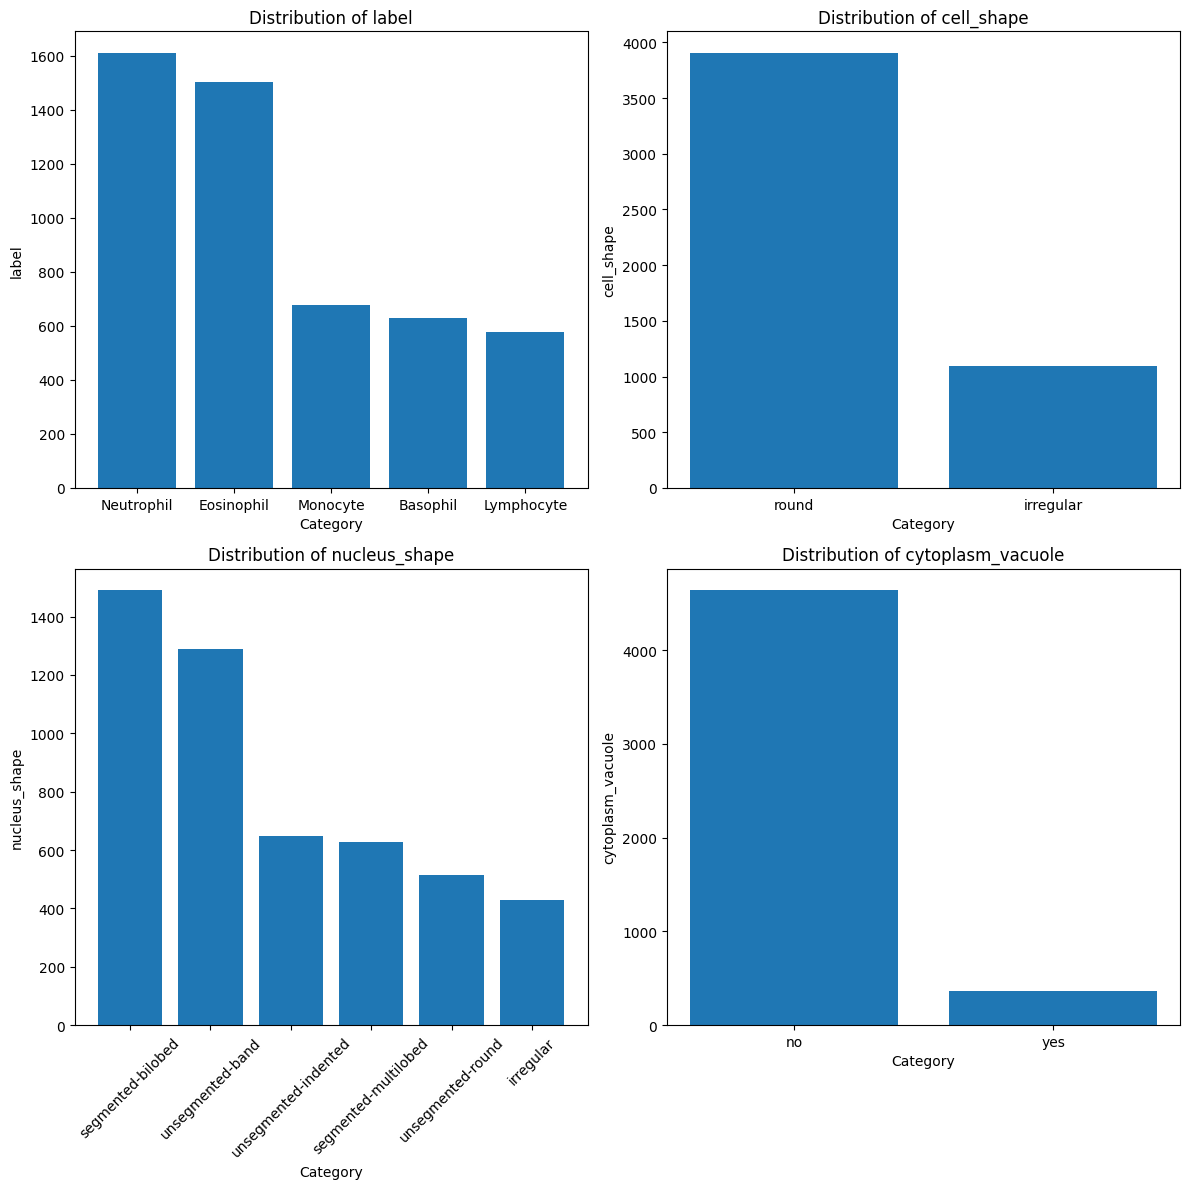

In [42]:
features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))  
axs = axs.flatten()

for i, feature in enumerate(features):
    counts = labels[feature].value_counts()
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel('Category')
    axs[i].set_ylabel(feature)
    
    if feature == 'nucleus_shape':
        axs[i].set_xticklabels(counts.index, rotation = 45)

plt.tight_layout()
plt.show()

We arre dealing with imbalanced classes basically for all separate classification tasks. I would like to tackle this issue by duplicating rare label combinations which will then be augmented and therefore be different. Additionally an metric is needed that considers these imbalances. We also need to condider a combined score of all predictions.  

In [43]:
class Image_multiplier():
    def __init__(self):
        self.rarities = {}
    
    def fit(self, labels, features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']):
        self.features = features
        for f in self.features:
            counts = labels[f].value_counts()
            max_count = counts.max()
            self.rarities[f] = {c: max_count / counts[c] for c in counts.index}

    def transform(self, labels):
        m_factors = []
        for _, row in labels.iterrows():
            raw_factors = np.prod([self.rarities[f][row[f]] for f in self.features])
            m_factors.append(int(np.floor(np.sqrt(raw_factors))))
        
        labels_repeated = labels.loc[labels.index.repeat(m_factors)].reset_index(drop=True)
        return labels_repeated

    def fit_transform(self, labels, features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']):
        self.fit(labels, features = features)
        return self.transform(labels)

In [44]:
data_train, data_val = train_test_split(labels, test_size=0.20, random_state=seed)

print(data_train.shape)
im = Image_multiplier()
data_train = im.fit_transform(data_train)
print(data_train.shape)

(4000, 5)
(9883, 5)


C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_36820\3642167846.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(counts.index, rotation = 45)


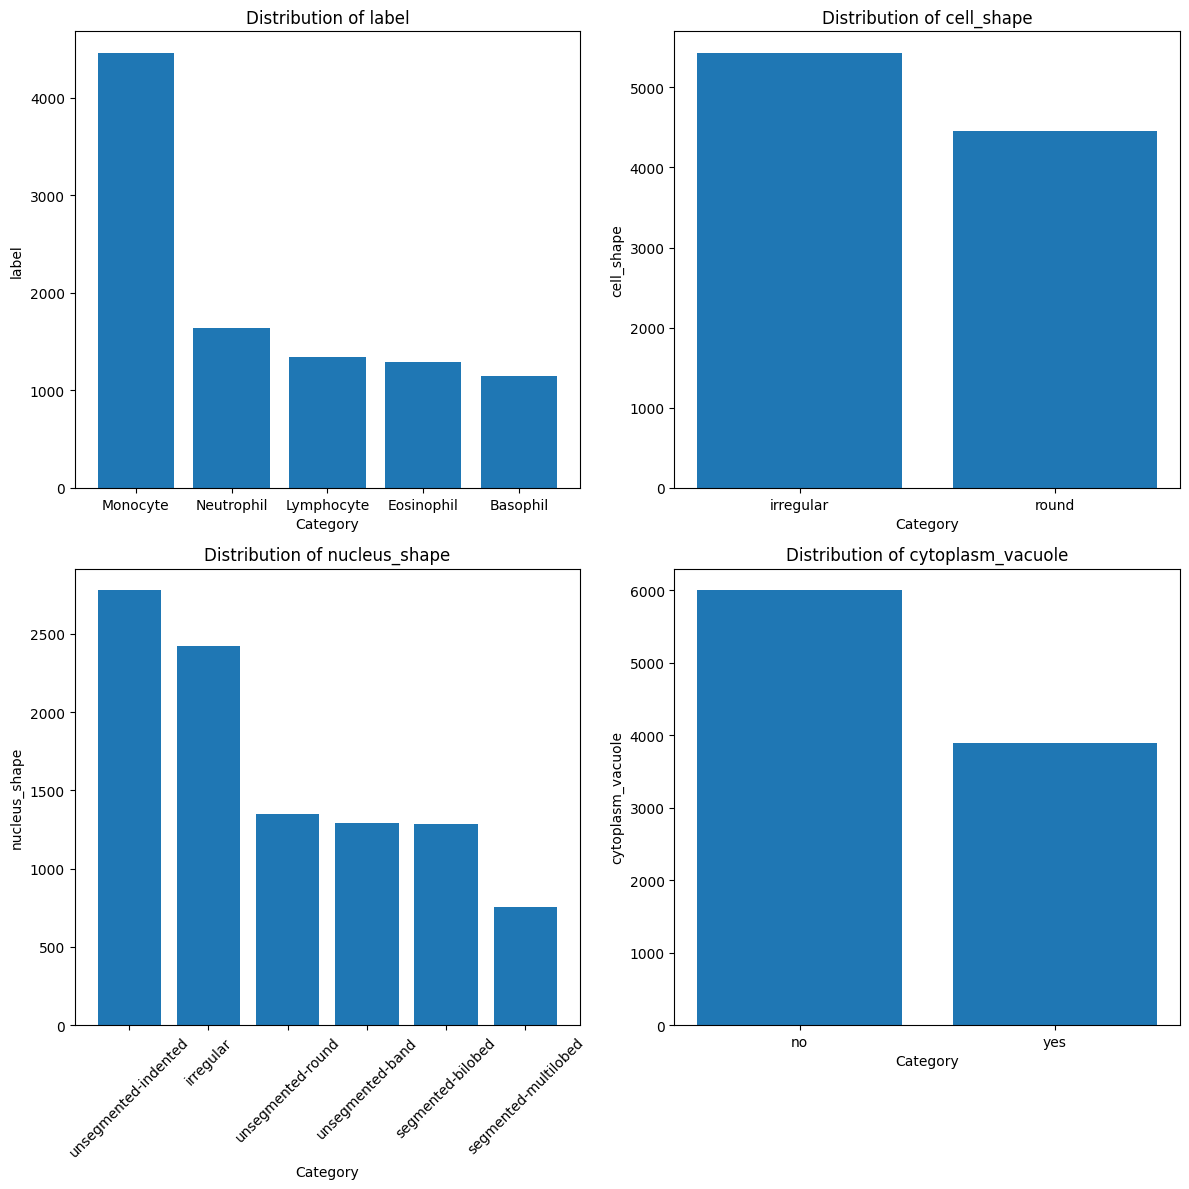

In [45]:
features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))  
axs = axs.flatten()

for i, feature in enumerate(features):
    counts = data_train[feature].value_counts()
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel('Category')
    axs[i].set_ylabel(feature)

    if feature == 'nucleus_shape':
        axs[i].set_xticklabels(counts.index, rotation = 45)

plt.tight_layout()
plt.show()

In [46]:
mapping_cv = {'yes':1, 'no':0}
mapping_shape = {'round':0, 'irregular':1}
mapping_type = {'Neutrophil':0, 'Eosinophil':1, 'Monocyte':2, 'Basophil':3, 'Lymphocyte':4}
mapping_nucleus = {'segmented-bilobed':1, 'unsegmented-band':2, 'unsegmented-indented':3, 'segmented-multilobed':4, 'unsegmented-round':5, 'irregular':0}

data_train['label'] = data_train['label'].map(mapping_type)
data_train['cell_shape'] = data_train['cell_shape'].map(mapping_shape)
data_train['nucleus_shape'] = data_train['nucleus_shape'].map(mapping_nucleus)
data_train['cytoplasm_vacuole'] = data_train['cytoplasm_vacuole'].map(mapping_cv)

data_val['label'] = data_val['label'].map(mapping_type)
data_val['cell_shape'] = data_val['cell_shape'].map(mapping_shape)
data_val['nucleus_shape'] = data_val['nucleus_shape'].map(mapping_nucleus)
data_val['cytoplasm_vacuole'] = data_val['cytoplasm_vacuole'].map(mapping_cv)

In [47]:
image_names_train = data_train['imageID']
image_names_val = data_val['imageID']

y_train = data_train.drop(columns=['imageID'])
y_val = data_val.drop(columns=['imageID'])

X_train = [image + '.jpg' for image in image_names_train]
X_val = [image + '.jpg' for image in image_names_val]

train_size = len(X_train)
val_size = len(X_val)

In [48]:
print(X_train[:5])
print(y_train.head(5))

['Img_03701.jpg', 'Img_00895.jpg', 'Img_02323.jpg', 'Img_04593.jpg', 'Img_03712.jpg']
   label  cell_shape  nucleus_shape  cytoplasm_vacuole
0      1           0              1                  0
1      1           0              1                  0
2      0           0              2                  0
3      0           0              2                  0
4      1           1              1                  0


In [ ]:
def load_image(image_filename, label):
  path = tf.strings.join([image_path, image_filename])
  image_raw = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image_raw, channels=3)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, image_size)

  label_shape = label[1]
  label_cv = label[3]
  label_label = tf.one_hot(label[0], 5)
  label_nucleus = tf.one_hot(label[2], 6)

  label = (label_label, label_shape, label_nucleus, label_cv)
  return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomBrightness(0.1, value_range=[0,255]),
    tf.keras.layers.RandomZoom(height_factor=(-0.15, 0.15), width_factor=(-0.3, 0.3), fill_mode='reflect'), 
    tf.keras.layers.RandomRotation(0.2),
  ])

def augment(image_filename ,labels):
  image, labels = load_image(image_filename, labels)

  image = data_augmentation(image)
  image = preprocess_input(image)

  return image, labels

BATCH_SIZE = 64
NUM_EXAMPLES = train_size
NUM_EXAMPLES_VAL = val_size

train_batches = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(buffer_size=NUM_EXAMPLES)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_batches = (
  tf.data.Dataset.from_tensor_slices((X_val, y_val))
  .take(NUM_EXAMPLES_VAL)
  .cache()
  .map(load_image)
  .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
  .batch(BATCH_SIZE)
)


In [187]:
rev_type = {v:k for k,v in mapping_type.items()}
rev_shape = {v:k for k,v in mapping_shape.items()}
rev_cv = {v:k for k,v in mapping_cv.items()}
rev_nucleus = {v:k for k,v in mapping_nucleus.items()}

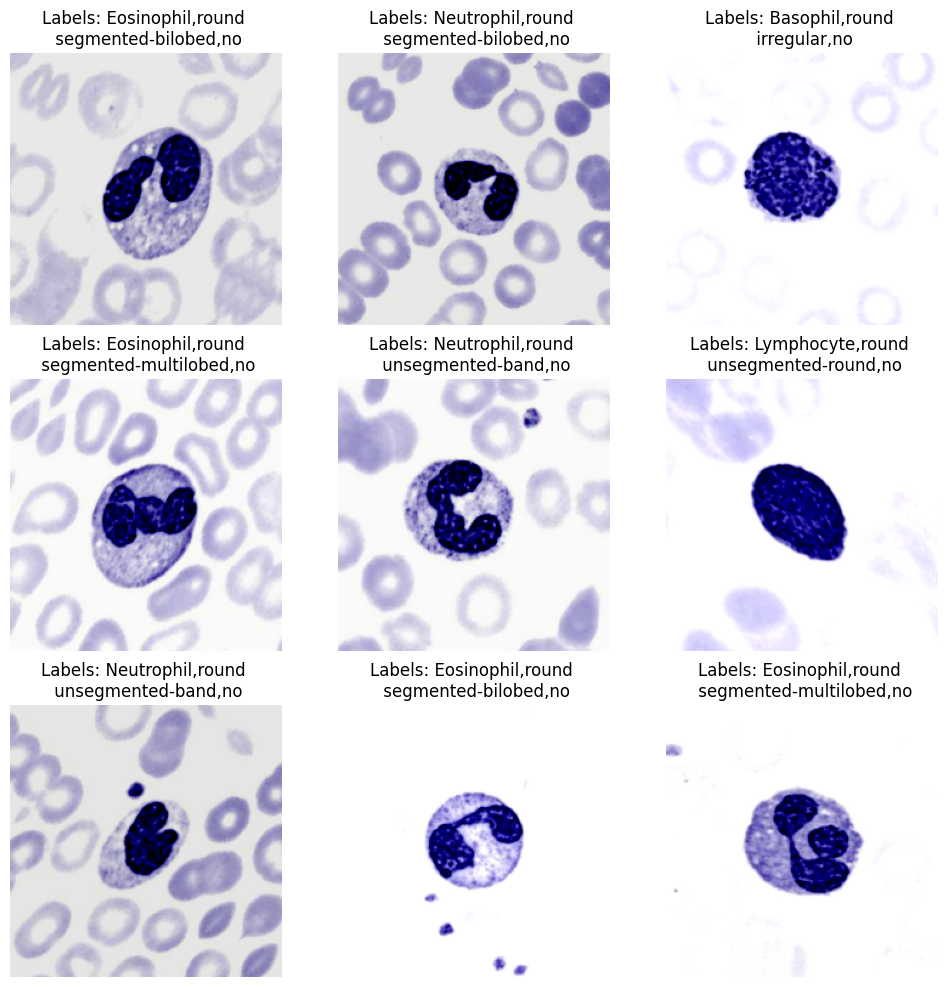

In [188]:
fig, axs = plt.subplots(3,3, figsize = (12,12))
axs = axs.flatten()

for images, labels in train_batches.take(1):    # images.shape = (batch_size, height, width, channels)
    for i in range(9):
        axs[i].imshow(images[i].numpy())
        axs[i].axis('off')
        label_type    = rev_type[tf.argmax(labels[0][i]).numpy()]
        label_shape   = rev_shape[labels[1][i].numpy()]
        label_nucleus = rev_nucleus[tf.argmax(labels[2][i]).numpy()]
        label_cv      = rev_cv[labels[3][i].numpy()]
        axs[i].set_title(f'Labels: {label_type},{label_shape} \n {label_nucleus},{label_cv}')
    break

- Do we need colour for this? 
- pretty much always in the middle of the picture. 
- There is no clear orientation - rotation, flipping can create a lot of images!

### Data augmentations to use:

- flipping! easily create more images and there is not really a correct direction random_flip_left_right(), random_flip_up_down
- Zoom - size shouldn't matter so I want to include this 
- hue random_hue()
- brightness adjusting random_brightness()
- i dont like cropping as I assume the automatic picture taking would have it in the middle usually. 



In [ ]:
def model_eval_comparison(history_dict, metric='f1'):
    fig, ax = plt.subplots()
    metric_keys = [k for k in history_dict.history.keys() if k.endswith(metric)]
    train_keys = sorted([k for k in metric_keys if not k.startswith('val_')])
    val_keys = sorted([k for k in metric_keys if k.startswith('val_')])
    colors = ['b', 'g', 'r', 'c']
    
    for c, train_key, val_key in zip(colors, train_keys, val_keys):
        y_train = history_dict.history[train_key]
        y_val = history_dict.history[val_key]
        epochs = range(len(y_val))

        ax.plot(epochs, y_train, c=c, linestyle='-', label=f'{train_key}')
        ax.plot(epochs, y_val, c=c, linestyle='--', label=f'{val_key}')

    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend()

### Discussing Outputs:
- Cell type: five different classes, includes the full cell
- Cell shape: binary (round, irregular), mostly interested in the border of the cell, should be at roughly the same position. Just want to find one circle, maybe use max?  
- Nucleus Shape: Can be at an arbitrary position, definitely different sizes. Global mapping needed.
- Cytoplasm Vaculole: Can be just a few in arbitrary position, maybe max more useful? 

In [190]:
def define_model(
    base = 'ResNet50V2',
    image_size = (224,224,3),
    hlayers_activation = 'relu'
    ):
  
    if base == 'ResNet50V2':
        base_model = tf.keras.applications.ResNet50(input_shape=image_size, include_top=False, weights='imagenet')
        base_model.trainable = False
    else:
        print('ERROR')
  
    input = tf.keras.layers.Input(shape=image_size)
    x = base_model(input, training=True)
    x_max = tf.keras.layers.GlobalMaxPooling2D()(x)
    x_avg = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    #Cell type
    x_1 = tf.keras.layers.Dense(64, activation=hlayers_activation)(x_avg)
    x_1 = tf.keras.layers.BatchNormalization()(x_1)
    x_1 = tf.keras.layers.Dropout(0.25)(x_1)
    output_1 = tf.keras.layers.Dense(5, activation='softmax')(x_1)

    #Cell Shape
    x_2 = tf.keras.layers.Dense(32, activation=hlayers_activation)(x_max)
    x_2 = tf.keras.layers.BatchNormalization()(x_2)
    x_2 = tf.keras.layers.Dropout(0.25)(x_2)
    output_2 = tf.keras.layers.Dense(1, activation='sigmoid')(x_2)

    #Nucleus Shape
    x_3 = tf.keras.layers.Dense(128, activation=hlayers_activation)(x_avg)
    x_3 = tf.keras.layers.BatchNormalization()(x_3)
    x_3 = tf.keras.layers.Dropout(0.25)(x_3)
    output_3 = tf.keras.layers.Dense(6, activation='softmax')(x_3)

    #Cytoplasm Vaculole
    x_4 = tf.keras.layers.Dense(16, activation=hlayers_activation)(x_max)
    x_4 = tf.keras.layers.BatchNormalization()(x_4)
    x_4 = tf.keras.layers.Dropout(0.15)(x_4)
    output_4 = tf.keras.layers.Dense(1, activation='sigmoid')(x_4)

    model = tf.keras.models.Model(inputs=input, outputs=[output_1, output_2, output_3, output_4])
    return model

In [191]:
baseline_model = define_model()

baseline_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_24[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │    131,136 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 32)        │     65,568 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 16)        │     32,784 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_40[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_42[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_44[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_46[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 16)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 5)         │        325 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1)         │         33 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 6)         │        774 │ dropout_22[0][0]

 Total params: 24,081,581 (91.86 MB)

 Trainable params: 493,389 (1.88 MB)

 Non-trainable params: 23,588,192 (89.98 MB)

In [197]:
# Chat GPT for NOW !!!
# ---------------------------
# Binary F1 (sigmoid outputs)
# ---------------------------
class binary_f1(tf.keras.metrics.Metric):
    def __init__(self, name="binary_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)  # convert probabilities to 0/1
        
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)
    
    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall = self.tp / (self.tp + self.fn + 1e-8)
        return 2 * (precision * recall) / (precision + recall + 1e-8)
    
    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

# ---------------------------
# Multi-class F1 (softmax outputs)
# y_true: one-hot, y_pred: softmax probabilities
# ---------------------------
class multiclass_f1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="multiclass_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", name="tp")
        self.fp = self.add_weight(shape=(num_classes,), initializer="zeros", name="fp")
        self.fn = self.add_weight(shape=(num_classes,), initializer="zeros", name="fn")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_labels = tf.argmax(y_true, axis=-1)
        y_pred_labels = tf.argmax(y_pred, axis=-1)

        for c in range(self.num_classes):
            y_true_c = tf.cast(tf.equal(y_true_labels, c), tf.float32)
            y_pred_c = tf.cast(tf.equal(y_pred_labels, c), tf.float32)
            
            # Use scatter_add to update the c-th element of the variable
            self.tp.assign(tf.tensor_scatter_nd_add(self.tp, [[c]], [tf.reduce_sum(y_true_c * y_pred_c)]))
            self.fp.assign(tf.tensor_scatter_nd_add(self.fp, [[c]], [tf.reduce_sum((1 - y_true_c) * y_pred_c)]))
            self.fn.assign(tf.tensor_scatter_nd_add(self.fn, [[c]], [tf.reduce_sum(y_true_c * (1 - y_pred_c))]))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall = self.tp / (self.tp + self.fn + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        return tf.reduce_mean(f1)

    def reset_state(self):
        self.tp.assign(tf.zeros_like(self.tp))
        self.fp.assign(tf.zeros_like(self.fp))
        self.fn.assign(tf.zeros_like(self.fn))

In [ ]:
histories = {}

baseline_model.compile(optimizer = tf.keras.optimizers.Adam(),
        loss=[
        "categorical_crossentropy",   
        "binary_crossentropy",        
        "categorical_crossentropy",   
        "binary_crossentropy"         
        ],
        metrics=[[multiclass_f1(5, name='label_f1')],
                 [binary_f1(name='shape_f1')],
                 [multiclass_f1(6, name='nucleus_f1')],
                 [binary_f1(name='cv_f1')]
                 ]

)
        
        

histories['base'] = baseline_model.fit(train_batches,
                                       epochs=10,
                                       validation_data=val_batches,
                                       verbose=1,
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - dense_41_label_f1: 0.6471 - dense_41_loss: 0.9524 - dense_43_loss: 0.6976 - dense_43_shape_f1: 0.2847 - dense_45_loss: 1.4736 - dense_45_nucleus_f1: 0.4167 - dense_47_cv_f1: 0.1267 - dense_47_loss: 0.7065 - loss: 3.8317 - val_dense_41_label_f1: 0.0475 - val_dense_41_loss: 1.6640 - val_dense_43_loss: 1.3742 - val_dense_43_shape_f1: 0.4132 - val_dense_45_loss: 1.7502 - val_dense_45_nucleus_f1: 0.1009 - val_dense_47_cv_f1: 0.0000e+00 - val_dense_47_loss: 0.4201 - val_loss: 5.1607
Epoch 2/10


KeyboardInterrupt: 

In [ ]:
reverse_mapping = {}

reverse_mapping['label'] = rev_type
reverse_mapping['cell_shape'] = rev_shape
reverse_mapping['nucleus_shape'] = rev_nucleus
reverse_mapping['cytoplasm_vacuole'] = rev_cv

features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

,label,cell_shape,nucleus_shape,cytoplasm_vacuole
2706,0,0,4,0
2436,0,1,2,0
1201,3,0,1,0
1486,1,0,1,0
4286,1,0,2,0
...,...,...,...,...
2230,0,0,2,0
2724,0,0,2,0
4891,1,0,4,0
4810,0,0,1,0


In [ ]:
def plot_confusion_matrix_from_batches(model, val_batches, y_true, mapping_tables = reverse_mapping, features = features):

    fig, axs = plt.subplots(2,2,figsize=(12,12))
    axs = axs.ravel()

    y_pred = model.predict(val_batches)
    print(f'Prediction shape is {y_pred.shape} assumed to be (n,12)')

    predictions = {}
    predictions[features[0]] = y_pred[:,:5]
    predictions[features[1]] = y_pred[:,5]
    predictions[features[2]] = y_pred[:,6:12]
    predictions[features[3]] = y_pred[:,12]

    for i,f in enumerate(features):
        y_pred = predictions[f]
        if y_pred.ndim > 1 and y_pred.shape[1] > 1:
            y_pred = np.argmax(y_pred, axis=1)

        cm = confusion_matrix(y_true[i], y_pred)


        class_names = [mapping_tables[j] for j in sorted(mapping_tables.keys())]

    
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                ax=axs[i], xticklabels=class_names, yticklabels=class_names)
        axs[i].set_ylabel('True label')
        axs[i].set_xlabel('Predicted label')
        axs[i].set_title(f'Confusion Matrix for {f}')

I trained a neural network on images to detect (cell type, nucleus shape, cell form and cytoplasm_vacuole). I have a model utilizing ResNet50v2 as a baseline with some additional dense layers. When visualizing the training and validation f1 score I have multiple problems: - The training for some of the heads seems very bad while for example the cell type seems reasonably good. The validation is fluxuating extremely sometimes even hitting zero. What could be some of the causes? I thought - I have to deal with class imbalances which could explain the fluxuations as some target classes might be heavily underrepresented in the validation set and it might predict just a few instances of that class. What happens to f1 score in a multiclass setting if one class has no correct predictions. - Maybe the training rate is too high and the model can overfit. But image augmentations change the training data such that it adapts to the new pictures. Do data augmentations get applied each training epoch new or do they remain the same? - Maybe the baseline of ResNet doesn't work as well for thee medical images. Might need finetuning or a different model.

Check metrics per class per head (confusion matrices, per-class precision/recall/F1) — see which classes drive instability.

Check class distribution in training and validation sets — consider stratified splitting.

Try weighted losses (class weights or focal loss) to stabilize learning for rare classes.

Track both macro-F1 and micro-F1 — micro will tell you if the overall accuracy trend is stable, macro highlights imbalance.

Try LR scheduling (warmup, cosine decay, or reduce-on-plateau).

Experiment with unfreezing more of ResNet to allow fine-tuning on your domain.

Data Exploration: Open Dataset and explore a few example pictures. 
Data Loader: Data Augmentation,
Model Design: Read some articles, find a model to orientate by. Use pre-existing/trained model! Build fine details of what will be important. Keep FC layers small to reduce used parameters, we are looking for local structure. Test different activation functions! What is the loss function we are creating? How are we choosing the optimizer. Include Gradient clipping/ previous layer connection to avoid exploding/vanishing gradients. Try momentum. Use BAtch Normalization (remove bias before), 
Compare to simple base models, a simple CNN with maybe two hidden layers. Regularization: Data Augmentation, Dropout,?, L2, l1? 

how does the output need to look like?  Classification of bloodcell type (0-4), cell shape(round, irregular),  Cytoplasm Vacuole (y/n), nucleeus shape (0-5)

## TODO 
- Find more models to use as base? Maybe something trained on cells?
- 